In [0]:
import csv
import json
import numpy as np
from keras.utils.np_utils import to_categorical




class ReadSongFeatureData:


    def read_json_file(self, path, genre):

        labels = []
        with open(path, 'r') as file:
            data = json.load(file)

            for i in data[1]:
                labels.append(genre)

        return data[1], labels

    def read_all_genres_json(self, genres):
        all_mfccs = []
        all_labels = []

        for genre in genres:
            single_genre_mfcc, single_genre_labels = self.read_json_file("%s.json" % genre, genre)
            all_mfccs.extend(single_genre_mfcc)
            all_labels.extend(single_genre_labels)



        label_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
        onehot_encoding_labels = to_categorical(label_row_ids, len(label_ids))



        return all_mfccs, onehot_encoding_labels





In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd "drive/My Drive/Colab Notebooks/30"


/content/drive/My Drive/Colab Notebooks/30


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation,BatchNormalization
from keras.regularizers import l2
import numpy as np
import random
from keras.optimizers import Adam



class CNN:

    def __init__(self):
      
        self.input_size = 1291
        self.genres = ['Folk', 'Hip-Hop', 'Pop', 'Rock', 'Instrumental']
        self.regularizer = l2(1e-5)
        self.model = self.get_CNN((20, self.input_size, 1))
        self.epoch = 60


    def get_CNN(self, shape):

        model = Sequential()
        model.add(Conv2D(input_shape=shape, kernel_size=(3, 3), filters=24, kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(Dropout(0.1))

        model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv2D(48, (3, 3), padding='same', kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(62, (3, 3), padding='same', kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.3))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2)))
        model.add(Dropout(0.3))



        model.add(Flatten())
        model.add(BatchNormalization())

        model.add(Dense(512, kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

        model.add(Dense(256, kernel_regularizer=self.regularizer))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))

        model.add(Dense(len(self.genres), activation='softmax'))

        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model


    def get_data(self):
        mfcc, label = self.get_mfcc_data_for_all_genres()

        mfcc, label = self.randomise_mfcc_label_order(label, mfcc)

        test_input, test_labels, train_input, train_labels = self.split_training_testing_data(mfcc, label)

        return train_input, train_labels, test_input, test_labels

    def randomise_mfcc_label_order(self, labels, mfcc):

        labels = list(labels)
        mfcc = list(mfcc)
        data = list(zip(labels, mfcc))
        random.shuffle(data)
        labels_shuffled, mfcc_shuffled = [], []
        labels_shuffled[:], mfcc_shuffled[:] = zip(*data)

        return mfcc_shuffled, labels_shuffled

    def get_mfcc_data_for_all_genres(self):


        reader = ReadSongFeatureData()
        mfcc, labels = reader.read_all_genres_json(self.genres)

        return mfcc, labels

    def split_training_testing_data(self, mfcc, labels):
        train_split = 0.9
        index = int(len(labels) * train_split)
        train_input = mfcc[:index]
        train_labels = labels[:index]
        test_input = mfcc[index:]
        test_labels = labels[index:]
        test_input = np.array(test_input)

        train_input = np.array(train_input)

        test_input = test_input.reshape(len(test_input), 20, self.input_size, 1)

        train_input = train_input.reshape(len(train_input), 20, self.input_size, 1)
        train_labels = np.array(train_labels)
        test_labels = np.array(test_labels)

        return test_input, test_labels, train_input, train_labels

    def fit_model(self):
        train_input, train_labels, test_input, test_labels = self.get_data()
        print('shape of train input ', np.shape(train_input))
        print('shape of train_labels ', np.shape(train_labels))
        print('shape of test_input ', np.shape(test_input))
        print('shape of test_labels ', np.shape(test_labels))
        
        self.model.fit(train_input, train_labels, epochs=self.epoch, batch_size=32, validation_split=0.1)
        loss, acc = self.model.evaluate(test_input, test_labels, batch_size=32)

        print("Loss: %.4f and Acc: %.4f" % (loss, acc))
        return self.model, loss, acc, test_input, test_labels



In [13]:
import pickle
cnn = CNN()

model, loss, acc, test_input, test_labels = cnn.fit_model()

model.save('model-acc %.4f- loss %.4f.h5' % (acc, loss))

with open('model-acc %.4f- loss %.4f - history' % (acc, loss), 'wb') as file_pi:
        pickle.dump(model.history, file_pi)


shape of train input  (4496, 20, 1291, 1)
shape of train_labels  (4496, 5)
shape of test_input  (500, 20, 1291, 1)
shape of test_labels  (500, 5)
Train on 4046 samples, validate on 450 samples
Epoch 1/60
4046/4046 [==============================] - 10s 3ms/step - loss: 1.4194 - acc: 0.3814 - val_loss: 6.6994 - val_acc: 0.2200
Epoch 2/60
4046/4046 [==============================] - 8s 2ms/step - loss: 1.2546 - acc: 0.4899 - val_loss: 2.8749 - val_acc: 0.2422
Epoch 3/60
4046/4046 [==============================] - 8s 2ms/step - loss: 1.2146 - acc: 0.5104 - val_loss: 2.7668 - val_acc: 0.2267
Epoch 4/60
4046/4046 [==============================] - 8s 2ms/step - loss: 1.2055 - acc: 0.5277 - val_loss: 1.4834 - val_acc: 0.4511
Epoch 5/60
4046/4046 [==============================] - 8s 2ms/step - loss: 1.1611 - acc: 0.5462 - val_loss: 1.3556 - val_acc: 0.4333
Epoch 6/60
4046/4046 [==============================] - 8s 2ms/step - loss: 1.1605 - acc: 0.5479 - val_loss: 1.1319 - val_acc: 0.5978
Ep

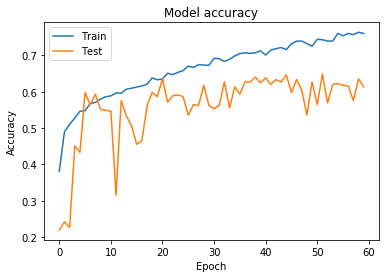

In [14]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

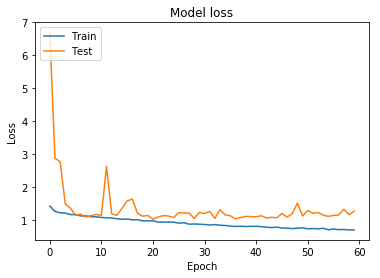

In [15]:

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix
pred = model.predict_classes(test_input, batch_size=32)
labels = []

for i in test_labels:
  labels.append(np.argmax(i))
cm = confusion_matrix(labels, pred)
print(cm)
def add_list(l):
  s = 0
  for i in l:
    s += i
  return s
s = 0
for i in range(len(cm)):
  s += cm[i][i] / add_list(cm[i])
  print(cm[i][i] / add_list(cm[i]))
print()
print(s / 5)
      

[[57  0 16 13 10]
 [ 0 55  2 30  3]
 [ 7  0 78 11 10]
 [16  8 12 42 18]
 [ 3  2 10 21 76]]
0.59375
0.6111111111111112
0.7358490566037735
0.4375
0.6785714285714286

0.6113563192572627
